In [1]:
############################################################ Webscraping.py #############################################################


from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
import zipfile
import io
import os
import time


# URL of the website to scrape
url = 'https://cricsheet.org/matches/'

# Send an HTTP GET request to the URL
response = requests.get(url)
response

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

# Get test matches link
test = "https://cricsheet.org" + soup.find('dt', string='Test matches').find_next_sibling('dd').find('a').get('href')

# Get T20 matches link
T20 = "https://cricsheet.org" + soup.find('dt', string='T20 internationals').find_next_sibling('dd').find('a').get('href')

# Get ODI matches link
ODI = "https://cricsheet.org" + soup.find('dt', string='One-day internationals').find_next_sibling('dd').find('a').get('href')

# Function to download and extract zip
def download_and_extract(url, folder_name):
    response = requests.get(url)

    try:
        z = zipfile.ZipFile(io.BytesIO(response.content))
        extract_path = os.path.join('/tmp', folder_name)
        os.makedirs(extract_path, exist_ok=True)  # Create the folder if it doesn't exist

        z.extractall(extract_path)
        print(f"Extraction successful for {folder_name}!")
    except Exception as e:
        print(f"Extraction failed for {folder_name}:", e)

# Function to get URL for each format
def url_for_format(format):
    if format == 'Test':
        return test
    elif format == 'ODI':
        return ODI
    elif format == 'T20':
        return T20

if __name__ == "__main__":
    download_and_extract(test, 'Test')
    download_and_extract(ODI, 'ODI')
    download_and_extract(T20, 'T20')

Extraction successful for Test!
Extraction successful for ODI!
Extraction successful for T20!


In [2]:
##################################################################### DATA CLEANING #####################################################################


# Transformation_Game_Details_pd.py


import os
import json
import pandas as pd

def transform_and_save_json(input_folder, output_folder):
    json_files = [f for f in os.listdir(input_folder) if f.endswith(".json")]

    transformed_data_list = []

    for json_file in json_files:
        input_path = os.path.join(input_folder, json_file)

        with open(input_path, "r") as input_file:
            data = json.load(input_file)

            outcome = data["info"]["outcome"].get("by")
            if isinstance(outcome, dict):
                outcome = f"{list(outcome.keys())[0]}: {list(outcome.values())[0]}"

            man_of_the_match = data["info"].get("player_of_match", [])
            if man_of_the_match:
                man_of_the_match = man_of_the_match[0]

            format_name = data["info"]["match_type"]  # Extract the format from JSON

            transformed_data = {
                "Team 1": data["info"]["teams"][0],
                "Team 2": data["info"]["teams"][1],
                "Team that Won": data["info"]["outcome"].get("winner", ""),
                "Outcome": outcome,
                "Date": data["info"]["dates"][0],
                "Venue": data["info"].get("city", "") + ", " + data["info"].get("venue", ""),
                "Man of the Match": man_of_the_match,
                "PK": json_file.split(".json")[0],
                "Format": format_name
            }

            transformed_data_list.append(transformed_data)

    df = pd.DataFrame(transformed_data_list, columns=["Team 1", "Team 2", "Team that Won", "Outcome", "Date", "Venue", "Man of the Match", "PK", "Format"])

    output_path = os.path.join(output_folder, "transformed_game_details.csv")
    df.to_csv(output_path, index=False)




In [3]:
# Paths to input and output folders
input_odi_folder = "/tmp/ODI"
output_odi_folder = "/tmp/ODI_transformed_game_details_pd"

input_t20_folder = "/tmp/T20"
output_t20_folder = "/tmp/T20_transformed_game_details_pd"

input_test_folder = "/tmp/Test"
output_test_folder = "/tmp/Test_transformed_game_details_pd"

os.makedirs(output_odi_folder, exist_ok=True)
os.makedirs(output_t20_folder, exist_ok=True)
os.makedirs(output_test_folder, exist_ok=True)

# Transform and save for each format
transform_and_save_json(input_odi_folder, output_odi_folder)
transform_and_save_json(input_t20_folder, output_t20_folder)
transform_and_save_json(input_test_folder, output_test_folder)


In [4]:
# Transformation_Batsman_Details_pd.py


import os
import json
import pandas as pd

def transform_and_save_batsman_details(input_folder, output_folder):
    json_files = [f for f in os.listdir(input_folder) if f.endswith(".json")]

    transformed_data_list = []

    for json_file in json_files:
        input_path = os.path.join(input_folder, json_file)

        with open(input_path, "r") as input_file:
            data = json.load(input_file)

            innings = data.get("innings", [])

            batsman_stats = {}

            for inning in innings:
                deliveries = inning.get("overs", [])
                for delivery in deliveries:
                    for ball in delivery.get("deliveries", []):
                        batter_name = ball.get("batter")
                        runs = ball.get("runs", {}).get("batter", 0)
                        extras = ball.get("runs", {}).get("extras", 0)
                        total_runs = runs + extras

                        if batter_name in batsman_stats:
                            batsman_stats[batter_name]["runs"] += total_runs
                            batsman_stats[batter_name]["balls"] += 1
                            if total_runs == 4:
                                batsman_stats[batter_name]["fours"] += 1
                            elif total_runs == 6:
                                batsman_stats[batter_name]["sixes"] += 1
                        else:
                            batsman_stats[batter_name] = {
                                "runs": total_runs,
                                "fours": 1 if total_runs == 4 else 0,
                                "sixes": 1 if total_runs == 6 else 0,
                                "balls": 1
                            }

            for batsman, stats in batsman_stats.items():
                balls_faced = stats["balls"]
                runs = stats["runs"]
                fours = stats["fours"]
                sixes = stats["sixes"]
                strike_rate = round((runs / balls_faced) * 100, 2) if balls_faced > 0 else 0.0
                country = data["info"]["teams"][0] if batsman in data["info"]["players"][data["info"]["teams"][0]] else data["info"]["teams"][1]

                transformed_data_list.append({
                    "PK": json_file.split(".json")[0],
                    "Batsman": batsman,
                    "Runs": runs,
                    "Fours": fours,
                    "Sixes": sixes,
                    "Balls Faced": balls_faced,
                    "Strike Rate": strike_rate,
                    "Country": country
                })

    df = pd.DataFrame(transformed_data_list, columns=["PK", "Batsman", "Runs", "Fours", "Sixes", "Balls Faced", "Strike Rate", "Country"])

    output_path = os.path.join(output_folder, "transformed_batsman_details.csv")
    df.to_csv(output_path, index=False)



In [5]:

# Paths for input folders and output folders
input_odi_folder = "/tmp/ODI"
output_odi_folder = "/tmp/ODI_transformed_batsmans_details_pd"

input_t20_folder = "/tmp/T20"
output_t20_folder = "/tmp/T20_transformed_batsmans_details_pd"

input_test_folder = "/tmp/Test"
output_test_folder = "/tmp/Test_transformed_batsmans_details_pd"

os.makedirs(output_odi_folder, exist_ok=True)
os.makedirs(output_t20_folder, exist_ok=True)
os.makedirs(output_test_folder, exist_ok=True)

# Transform and save batsman details for each format
transform_and_save_batsman_details(input_odi_folder, output_odi_folder)
transform_and_save_batsman_details(input_t20_folder, output_t20_folder)
transform_and_save_batsman_details(input_test_folder, output_test_folder)

In [6]:
# Transformation_Bowler_Details_pd.py

import os
import json
import pandas as pd

def transform_and_save_bowler_details(input_folder, output_folder):
    json_files = [f for f in os.listdir(input_folder) if f.endswith(".json")]

    transformed_data_list = []

    for json_file in json_files:
        input_path = os.path.join(input_folder, json_file)

        with open(input_path, "r") as input_file:
            data = json.load(input_file)

            innings = data.get("innings", [])

            bowler_stats = {}

            for inning in innings:
                deliveries = inning.get("overs", [])
                for delivery in deliveries:
                    for ball in delivery.get("deliveries", []):
                        bowler_name = ball.get("bowler")
                        runs_conceded = ball.get("runs", {}).get("total", 0)
                        wickets = ball.get("wickets", [])

                        if bowler_name in bowler_stats:
                            bowler_stats[bowler_name]["runs_given"] += runs_conceded
                            bowler_stats[bowler_name]["balls_thrown"] += 1
                            bowler_stats[bowler_name]["wickets"] += len(wickets)
                        else:
                            bowler_stats[bowler_name] = {
                                "wickets": len(wickets),
                                "runs_given": runs_conceded,
                                "balls_thrown": 1
                            }

            for bowler, stats in bowler_stats.items():
                wickets_taken = stats["wickets"]
                runs_given = stats["runs_given"]
                balls_thrown = stats["balls_thrown"]
                economy = round((runs_given / balls_thrown) * 6, 2) if balls_thrown > 0 else 0.0
                bowling_strike_rate = round((balls_thrown / wickets_taken), 2) if wickets_taken > 0 else 0.0

                transformed_data_list.append({
                    "PK": json_file.split(".json")[0],
                    "Bowler": bowler,
                    "Team": data["info"]["teams"][0] if bowler in data["info"]["players"][data["info"]["teams"][0]] else data["info"]["teams"][1],
                    "Wickets Taken": wickets_taken,
                    "Runs Given": runs_given,
                    "Economy": economy,
                    "Bowling Strike Rate": bowling_strike_rate
                })

    df = pd.DataFrame(transformed_data_list, columns=["PK", "Bowler", "Team", "Wickets Taken", "Runs Given", "Economy", "Bowling Strike Rate"])

    output_path = os.path.join(output_folder, "transformed_bowler_details.csv")
    df.to_csv(output_path, index=False)




In [7]:
# Paths for input folders and output folders
input_odi_folder = "/tmp/ODI"
output_odi_folder = "/tmp/ODI_transformed_bowlers_details_pd"

input_t20_folder = "/tmp/T20"
output_t20_folder = "/tmp/T20_transformed_bowlers_details_pd"

input_test_folder = "/tmp/Test"
output_test_folder = "/tmp/Test_transformed_bowlers_details_pd"

os.makedirs(output_odi_folder, exist_ok=True)
os.makedirs(output_t20_folder, exist_ok=True)
os.makedirs(output_test_folder, exist_ok=True)

# Transform and save bowlers details for each format
transform_and_save_bowler_details(input_odi_folder, output_odi_folder)
transform_and_save_bowler_details(input_t20_folder, output_t20_folder)
transform_and_save_bowler_details(input_test_folder, output_test_folder)

In [8]:
# Transformation_Fielder_Details_pd.py

import os
import json
import pandas as pd

def transform_and_save_fielder_details(input_folder, output_folder):
    json_files = [f for f in os.listdir(input_folder) if f.endswith(".json")]

    transformed_data_list = []

    for json_file in json_files:
        input_path = os.path.join(input_folder, json_file)

        with open(input_path, "r") as input_file:
            data = json.load(input_file)

            innings = data.get("innings", [])

            fielder_stats = {}

            for inning in innings:
                deliveries = inning.get("overs", [])
                for delivery in deliveries:
                    for ball in delivery.get("deliveries", []):
                        wickets = ball.get("wickets", [])
                        for wicket in wickets:
                            player_out = wicket.get("player_out")
                            fielders = wicket.get("fielders", [])
                            if player_out and fielders:
                                for fielder in fielders:
                                    fielder_name = fielder.get("name")
                                    method_of_out = wicket.get("kind", "")

                                    if fielder_name in fielder_stats:
                                        fielder_stats[fielder_name]["dismissals"] += 1
                                    else:
                                        fielder_stats[fielder_name] = {
                                            "dismissals": 1,
                                            "team": data["info"]["teams"][0] if fielder_name in data["info"]["players"][data["info"]["teams"][0]] else data["info"]["teams"][1],
                                            "method_of_out": method_of_out
                                        }

            for fielder, stats in fielder_stats.items():
                transformed_data_list.append({
                    "PK": json_file.split(".json")[0],
                    "Fielder": fielder,
                    "Team": stats["team"],
                    "Dismissals": stats["dismissals"],
                    "Method of Out": stats["method_of_out"]
                })

    df = pd.DataFrame(transformed_data_list, columns=["PK", "Fielder", "Team", "Dismissals", "Method of Out"])

    output_path = os.path.join(output_folder, "transformed_fielder_details.csv")
    df.to_csv(output_path, index=False)




In [9]:
# Paths for input folders and output folders
input_odi_folder = "/tmp/ODI"
output_odi_folder = "/tmp/ODI_transformed_fielder_details_pd"

input_t20_folder = "/tmp/T20"
output_t20_folder = "/tmp/T20_transformed_fielder_details_pd"

input_test_folder = "/tmp/Test"
output_test_folder = "/tmp/Test_transformed_fielder_details_pd"

os.makedirs(output_odi_folder, exist_ok=True)
os.makedirs(output_t20_folder, exist_ok=True)
os.makedirs(output_test_folder, exist_ok=True)

# Transform and save fielder details for each format
transform_and_save_fielder_details(input_odi_folder, output_odi_folder)
transform_and_save_fielder_details(input_t20_folder, output_t20_folder)
transform_and_save_fielder_details(input_test_folder, output_test_folder)

In [10]:
# Gamedetails Dataframe:

import pandas as pd

csv_files = [
    "/tmp/ODI_transformed_game_details_pd/transformed_game_details.csv",
    "/tmp/T20_transformed_game_details_pd/transformed_game_details.csv",
    "/tmp/Test_transformed_game_details_pd/transformed_game_details.csv"
]

# Read and merge CSV files into a single dataframe
game_details_df = pd.concat([pd.read_csv(csv_file) for csv_file in csv_files], ignore_index=True)

# # Display the merged dataframe
# print(game_details_df).head()

output_csv_path = "/tmp/All_game_details.csv"
game_details_df.to_csv(output_csv_path, index=False)


In [11]:
# Batsman Dataframe:

import pandas as pd

# List of CSV files to be merged
csv_files = [
    "/tmp/ODI_transformed_batsmans_details_pd/transformed_batsman_details.csv",
    "/tmp/T20_transformed_batsmans_details_pd/transformed_batsman_details.csv",
    "/tmp/Test_transformed_batsmans_details_pd/transformed_batsman_details.csv"
]

# Read and merge CSV files into a single dataframe
batsman_df = pd.concat([pd.read_csv(csv_file) for csv_file in csv_files], ignore_index=True)

# # Display the merged dataframe
# print(batsman_df).head()

# Save the merged dataframe to a new CSV file
output_csv_path = "/tmp/All_batsman_details.csv"
batsman_df.to_csv(output_csv_path, index=False)


In [12]:
# Bowler Dataframe:


import pandas as pd

# List of CSV files to be merged
csv_files = [
    "/tmp/ODI_transformed_bowlers_details_pd/transformed_bowler_details.csv",
    "/tmp/T20_transformed_bowlers_details_pd/transformed_bowler_details.csv",
    "/tmp/Test_transformed_bowlers_details_pd/transformed_bowler_details.csv"
]

# Read and merge CSV files into a single dataframe
bowler_df = pd.concat([pd.read_csv(csv_file) for csv_file in csv_files], ignore_index=True)

# # Display the merged dataframe
# print(bowler_df).head()

# Save the merged dataframe to a new CSV file
output_csv_path = "/tmp/All_bowler_details.csv"
bowler_df.to_csv(output_csv_path, index=False)


In [13]:
# Fielder Dataframe:

import pandas as pd

# List of CSV files to be merged
csv_files = [
    "/tmp/ODI_transformed_fielder_details_pd/transformed_fielder_details.csv",
    "/tmp/T20_transformed_fielder_details_pd/transformed_fielder_details.csv",
    "/tmp/Test_transformed_fielder_details_pd/transformed_fielder_details.csv"
]

# Read and merge CSV files into a single dataframe
fielder_df = pd.concat([pd.read_csv(csv_file) for csv_file in csv_files], ignore_index=True)

# # Display the merged dataframe
# print(fielder_df).head()

# Save the merged dataframe to a new CSV file
output_csv_path = "/tmp/All_fielder_details.csv"
fielder_df.to_csv(output_csv_path, index=False)



In [ ]:
# ## Uploading done using AWS Cloud9

# import pandas as pd
# import psycopg2
# import os

# # Database connection parameters
# db_params = {
#     "host": "data-sandbox.c1tykfvfhpit.eu-west-2.rds.amazonaws.com",
#     "database": "pagila",
#     "user": "de8_azku38",
#     "password": "DGrez03-"
# }

# # Define columns for each format
# format_columns = {
#     "game": [
#         ("Team 1", "TEXT"),
#         ("Team 2", "TEXT"),
#         ("Team that Won", "TEXT"),
#         ("Outcome", "TEXT"),
#         ("Date", "DATE"),
#         ("Venue", "TEXT"),
#         ("Man of the Match", "TEXT"),
#         ("PK", "VARCHAR(255)"),
#     ],
#     "batsman": [
#         ("Batsman", "TEXT"),
#         ("Runs", "INT"),
#         ("Fours", "INT"),
#         ("Sixes", "INT"),
#         ("Balls Faced", "INT"),
#         ("Strike Rate", "FLOAT(2)"),
#         ("Country", "TEXT"),
#         ("PK", "VARCHAR(255)"),
#     ],
#     "bowler": [
#         ("PK", "VARCHAR(255)"),
#         ("Bowler", "TEXT"),
#         ("Team", "TEXT"),
#         ("Wickets Taken", "INT"),
#         ("Runs Given", "INT"),
#         ("Economy", "FLOAT(2)"),
#         ("Bowling Strike Rate", "FLOAT(2)"),
#     ],
#     "fielder": [
#         ("Fielder", "TEXT"),
#         ("Catches", "INT"),
#         ("Run Outs", "INT"),
#         ("Stumpings", "INT"),
#         ("Country", "TEXT"),
#         ("PK", "VARCHAR(255)"),
#     ]
# }

# # Paths to the CSV files for each format
# csv_files_by_format = {
#     "game": [
#         "/tmp/ODI_transformed_game_details_pd/transformed_game_details.csv",
#         "/tmp/T20_transformed_game_details_pd/transformed_game_details.csv",
#         "/tmp/Test_transformed_game_details_pd/transformed_game_details.csv"
#     ],
#     "batsman": [
#         "/tmp/ODI_transformed_batsmans_details_pd/transformed_batsman_details.csv",
#         "/tmp/T20_transformed_batsmans_details_pd/transformed_batsman_details.csv",
#         "/tmp/Test_transformed_batsmans_details_pd/transformed_batsman_details.csv"
#     ],
#     "bowler": [
#         "/tmp/ODI_transformed_bowlers_details_pd/transformed_bowler_details.csv",
#         "/tmp/T20_transformed_bowlers_details_pd/transformed_bowler_details.csv",
#         "/tmp/Test_transformed_bowlers_details_pd/transformed_bowler_details.csv"
#     ],
#     "fielder": [
#         "/tmp/ODI_transformed_fielder_details_pd/transformed_filder_details.csv",
#         "/tmp/T20_transformed_fielder_details_pd/transformed_filder_details.csv",
#         "/tmp/Test_transformed_fielder_details_pd/transformed_filder_details.csv"
#     ]
# }

# # Establish connection to the database
# try:
#     conn = psycopg2.connect(**db_params)
#     cursor = conn.cursor()

#     for format_name, csv_files in csv_files_by_format.items():
#         for csv_file in csv_files:
#             table_name = "AK_" + os.path.basename(csv_file).split("_")[1] + "_Details"
#             csv_df = pd.read_csv(csv_file)

#             # Check if the table exists, and create it if necessary
#             create_table_query = f"CREATE TABLE IF NOT EXISTS pagila.student.{table_name} ("
#             columns = format_columns[format_name]
#             for column_name, column_type in columns:
#                 create_table_query += f'"{column_name}" {column_type}, '
#             if format_name == "game":
#                 create_table_query += '"Format" TEXT, '
#             create_table_query = create_table_query[:-2] + ")"

#             cursor.execute(create_table_query)
#             conn.commit()

#             # Upload new data to the database
#             for index, row in csv_df.iterrows():
#                 insert_query = f"INSERT INTO {table_name} ("
#                 for column_name, _ in columns:
#                     insert_query += f'"{column_name}", '
#                 if format_name == "game":
#                     insert_query += '"Format", '
#                 insert_query = insert_query[:-2] + ") VALUES ("
#                 placeholders = ", ".join(["%s"] * len(columns))
#                 if format_name == "game":
#                     placeholders += ", %s"
#                 insert_query += placeholders + ")"

#                 values = [row[column_name] for column_name, _ in columns]
#                 if format_name == "game":
#                     values.append(row["Format"])
#                 cursor.execute(insert_query, tuple(values))
#                 conn.commit()

# except psycopg2.Error as e:
#     print("Error:", e)

# finally:
#     if conn:
#         conn.close()



In [14]:
# Check the website and Update the new json file in new_ODI, new_T20, new_Test


import time
import os
import shutil

def get_extracted_files(format):
    path = f'/tmp/{format}'
    files = os.listdir(path)
    return set(files)

def update(format):
    existing = get_extracted_files(format)

    # Get latest files
    url = url_for_format(format)
    download_and_extract(url, format)

    new = get_extracted_files(format) - existing
    print(f"Found {len(new)} new {format} files")

    new_dir = f'/tmp/new_{format}'
    os.makedirs(new_dir, exist_ok=True)  # Create the new directory if it doesn't exist

    for file in new:
        old_path = f'/tmp/{format}/{file}'
        new_path = os.path.join(new_dir, file)  # New path in the new_format directory
        shutil.copy(old_path, new_path)
        print(f"Copied {file} to new_{format} directory")


while True:
    update('Test')
    update('ODI')
    update('T20')
    break
    # time.sleep(3600)

Extraction successful for Test!
Found 0 new Test files
Extraction successful for ODI!
Found 0 new ODI files
Extraction successful for T20!
Found 0 new T20 files


In [28]:
# Incremntal update

####################### New Game Details: ######################################

# def transform_and_save_json(input_folder, output_folder):
#     json_files = [f for f in os.listdir(input_folder) if f.endswith(".json")]

#     transformed_data_list = []

#     for json_file in json_files:
#         input_path = os.path.join(input_folder, json_file)

#         with open(input_path, "r") as input_file:
#             data = json.load(input_file)

#             outcome = data["info"]["outcome"].get("by")
#             if isinstance(outcome, dict):
#                 outcome = f"{list(outcome.keys())[0]}: {list(outcome.values())[0]}"

#             man_of_the_match = data["info"].get("player_of_match", [])
#             if man_of_the_match:
#                 man_of_the_match = man_of_the_match[0]

#             format_name = data["info"]["match_type"]  # Extract the format from JSON

#             transformed_data = {
#                 "Team 1": data["info"]["teams"][0],
#                 "Team 2": data["info"]["teams"][1],
#                 "Team that Won": data["info"]["outcome"].get("winner", ""),
#                 "Outcome": outcome,
#                 "Date": data["info"]["dates"][0],
#                 "Venue": data["info"].get("city", "") + ", " + data["info"].get("venue", ""),
#                 "Man of the Match": man_of_the_match,
#                 "PK": json_file.split(".json")[0],
#                 "Format": format_name
#             }

#             transformed_data_list.append(transformed_data)

#     df = pd.DataFrame(transformed_data_list, columns=["Team 1", "Team 2", "Team that Won", "Outcome", "Date", "Venue", "Man of the Match", "PK", "Format"])

#     output_path = os.path.join(output_folder, "new_transformed_game_details.csv")
#     df.to_csv(output_path, index=False)

# Paths to input and output folders
input_odi_folder = "/tmp/new_ODI"
output_odi_folder = "/tmp/new_ODI_transformed_game_details_pd"

input_t20_folder = "/tmp/new_T20"
output_t20_folder = "/tmp/new_T20_transformed_game_details_pd"

input_test_folder = "/tmp/new_Test"
output_test_folder = "/tmp/new_Test_transformed_game_details_pd"

os.makedirs(output_odi_folder, exist_ok=True)
os.makedirs(output_t20_folder, exist_ok=True)
os.makedirs(output_test_folder, exist_ok=True)

# Transform and save for each format
transform_and_save_json(input_odi_folder, output_odi_folder)
transform_and_save_json(input_t20_folder, output_t20_folder)
transform_and_save_json(input_test_folder, output_test_folder)

# time.sleep(3600)





In [29]:
########################### New Batsman Details ##################################

# def transform_and_save_batsman_details(input_folder, output_folder):
#     json_files = [f for f in os.listdir(input_folder) if f.endswith(".json")]

#     transformed_data_list = []

#     for json_file in json_files:
#         input_path = os.path.join(input_folder, json_file)

#         with open(input_path, "r") as input_file:
#             data = json.load(input_file)

#             innings = data.get("innings", [])

#             batsman_stats = {}

#             for inning in innings:
#                 deliveries = inning.get("overs", [])
#                 for delivery in deliveries:
#                     for ball in delivery.get("deliveries", []):
#                         batter_name = ball.get("batter")
#                         runs = ball.get("runs", {}).get("batter", 0)
#                         extras = ball.get("runs", {}).get("extras", 0)
#                         total_runs = runs + extras

#                         if batter_name in batsman_stats:
#                             batsman_stats[batter_name]["runs"] += total_runs
#                             batsman_stats[batter_name]["balls"] += 1
#                             if total_runs == 4:
#                                 batsman_stats[batter_name]["fours"] += 1
#                             elif total_runs == 6:
#                                 batsman_stats[batter_name]["sixes"] += 1
#                         else:
#                             batsman_stats[batter_name] = {
#                                 "runs": total_runs,
#                                 "fours": 1 if total_runs == 4 else 0,
#                                 "sixes": 1 if total_runs == 6 else 0,
#                                 "balls": 1
#                             }

#             for batsman, stats in batsman_stats.items():
#                 balls_faced = stats["balls"]
#                 runs = stats["runs"]
#                 fours = stats["fours"]
#                 sixes = stats["sixes"]
#                 strike_rate = round((runs / balls_faced) * 100, 2) if balls_faced > 0 else 0.0
#                 country = data["info"]["teams"][0] if batsman in data["info"]["players"][data["info"]["teams"][0]] else data["info"]["teams"][1]

#                 transformed_data_list.append({
#                     "PK": json_file.split(".json")[0],
#                     "Batsman": batsman,
#                     "Runs": runs,
#                     "Fours": fours,
#                     "Sixes": sixes,
#                     "Balls Faced": balls_faced,
#                     "Strike Rate": strike_rate,
#                     "Country": country
#                 })

#     df = pd.DataFrame(transformed_data_list, columns=["PK", "Batsman", "Runs", "Fours", "Sixes", "Balls Faced", "Strike Rate", "Country"])

#     output_path = os.path.join(output_folder, "new_transformed_batsman_details.csv")
#     df.to_csv(output_path, index=False)

# Paths for input folders and output folders
input_odi_folder = "/tmp/new_ODI"
output_odi_folder = "/tmp/new_ODI_transformed_batsmans_details_pd"

input_t20_folder = "/tmp/new_T20"
output_t20_folder = "/tmp/new_T20_transformed_batsmans_details_pd"

input_test_folder = "/tmp/new_Test"
output_test_folder = "/tmp/new_Test_transformed_batsmans_details_pd"

os.makedirs(output_odi_folder, exist_ok=True)
os.makedirs(output_t20_folder, exist_ok=True)
os.makedirs(output_test_folder, exist_ok=True)

# Transform and save batsman details for each format
transform_and_save_batsman_details(input_odi_folder, output_odi_folder)
transform_and_save_batsman_details(input_t20_folder, output_t20_folder)
transform_and_save_batsman_details(input_test_folder, output_test_folder)

# time.sleep(3600)






In [30]:
#################################### New Bowler Details: #####################################


# # Transformation_Bowler_Details_pd.py

# import os
# import json
# import pandas as pd

# def transform_and_save_bowler_details(input_folder, output_folder):
#     json_files = [f for f in os.listdir(input_folder) if f.endswith(".json")]

#     transformed_data_list = []

#     for json_file in json_files:
#         input_path = os.path.join(input_folder, json_file)

#         with open(input_path, "r") as input_file:
#             data = json.load(input_file)

#             innings = data.get("innings", [])

#             bowler_stats = {}

#             for inning in innings:
#                 deliveries = inning.get("overs", [])
#                 for delivery in deliveries:
#                     for ball in delivery.get("deliveries", []):
#                         bowler_name = ball.get("bowler")
#                         runs_conceded = ball.get("runs", {}).get("total", 0)
#                         wickets = ball.get("wickets", [])

#                         if bowler_name in bowler_stats:
#                             bowler_stats[bowler_name]["runs_given"] += runs_conceded
#                             bowler_stats[bowler_name]["balls_thrown"] += 1
#                             bowler_stats[bowler_name]["wickets"] += len(wickets)
#                         else:
#                             bowler_stats[bowler_name] = {
#                                 "wickets": len(wickets),
#                                 "runs_given": runs_conceded,
#                                 "balls_thrown": 1
#                             }

#             for bowler, stats in bowler_stats.items():
#                 wickets_taken = stats["wickets"]
#                 runs_given = stats["runs_given"]
#                 balls_thrown = stats["balls_thrown"]
#                 economy = round((runs_given / balls_thrown) * 6, 2) if balls_thrown > 0 else 0.0
#                 bowling_strike_rate = round((balls_thrown / wickets_taken), 2) if wickets_taken > 0 else 0.0

#                 transformed_data_list.append({
#                     "PK": json_file.split(".json")[0],
#                     "Bowler": bowler,
#                     "Team": data["info"]["teams"][0] if bowler in data["info"]["players"][data["info"]["teams"][0]] else data["info"]["teams"][1],
#                     "Wickets Taken": wickets_taken,
#                     "Runs Given": runs_given,
#                     "Economy": economy,
#                     "Bowling Strike Rate": bowling_strike_rate
#                 })

#     df = pd.DataFrame(transformed_data_list, columns=["PK", "Bowler", "Team", "Wickets Taken", "Runs Given", "Economy", "Bowling Strike Rate"])

#     output_path = os.path.join(output_folder, "new_transformed_bowler_details.csv")
#     df.to_csv(output_path, index=False)

# Paths for input folders and output folders
input_odi_folder = "/tmp/new_ODI"
output_odi_folder = "/tmp/new_ODI_transformed_bowlers_details_pd"

input_t20_folder = "/tmp/new_T20"
output_t20_folder = "/tmp/new_T20_transformed_bowlers_details_pd"

input_test_folder = "/tmp/new_Test"
output_test_folder = "/tmp/new_Test_transformed_bowlers_details_pd"

os.makedirs(output_odi_folder, exist_ok=True)
os.makedirs(output_t20_folder, exist_ok=True)
os.makedirs(output_test_folder, exist_ok=True)


# Transform and save bowlers details for each format
transform_and_save_bowler_details(input_odi_folder, output_odi_folder)
transform_and_save_bowler_details(input_t20_folder, output_t20_folder)
transform_and_save_bowler_details(input_test_folder, output_test_folder)

# time.sleep(180)



In [31]:
##################################### New Fielder Details #####################################

# Transformation_Fielder_Details_pd.py

# import os
# import json
# import pandas as pd

# def transform_and_save_fielder_details(input_folder, output_folder):
#     json_files = [f for f in os.listdir(input_folder) if f.endswith(".json")]

#     transformed_data_list = []

#     for json_file in json_files:
#         input_path = os.path.join(input_folder, json_file)

#         with open(input_path, "r") as input_file:
#             data = json.load(input_file)

#             innings = data.get("innings", [])

#             fielder_stats = {}

#             for inning in innings:
#                 deliveries = inning.get("overs", [])
#                 for delivery in deliveries:
#                     for ball in delivery.get("deliveries", []):
#                         wickets = ball.get("wickets", [])
#                         for wicket in wickets:
#                             player_out = wicket.get("player_out")
#                             fielders = wicket.get("fielders", [])
#                             if player_out and fielders:
#                                 for fielder in fielders:
#                                     fielder_name = fielder.get("name")
#                                     method_of_out = wicket.get("kind", "")

#                                     if fielder_name in fielder_stats:
#                                         fielder_stats[fielder_name]["dismissals"] += 1
#                                     else:
#                                         fielder_stats[fielder_name] = {
#                                             "dismissals": 1,
#                                             "team": data["info"]["teams"][0] if fielder_name in data["info"]["players"][data["info"]["teams"][0]] else data["info"]["teams"][1],
#                                             "method_of_out": method_of_out
#                                         }

#             for fielder, stats in fielder_stats.items():
#                 transformed_data_list.append({
#                     "PK": json_file.split(".json")[0],
#                     "Fielder": fielder,
#                     "Team": stats["team"],
#                     "Dismissals": stats["dismissals"],
#                     "Method of Out": stats["method_of_out"]
#                 })

#     df = pd.DataFrame(transformed_data_list, columns=["PK", "Fielder", "Team", "Dismissals", "Method of Out"])

#     output_path = os.path.join(output_folder, "new_transformed_fielder_details.csv")
#     df.to_csv(output_path, index=False)

# Paths for input folders and output folders
input_odi_folder = "/tmp/new_ODI"
output_odi_folder = "/tmp/new_ODI_transformed_fielder_details_pd"

input_t20_folder = "/tmp/new_T20"
output_t20_folder = "/tmp/new_T20_transformed_fielder_details_pd"

input_test_folder = "/tmp/new_Test"
output_test_folder = "/tmp/new_Test_transformed_fielder_details_pd"

os.makedirs(output_odi_folder, exist_ok=True)
os.makedirs(output_t20_folder, exist_ok=True)
os.makedirs(output_test_folder, exist_ok=True)

# Transform and save fielder details for each format
transform_and_save_fielder_details(input_odi_folder, output_odi_folder)
transform_and_save_fielder_details(input_t20_folder, output_t20_folder)
transform_and_save_fielder_details(input_test_folder, output_test_folder)

# time.sleep(180)


In [32]:
##################### Uploading new file to Database ###################################


import pandas as pd
import psycopg2
import os

# Database connection parameters
db_params = {
    "host": "data-sandbox.c1tykfvfhpit.eu-west-2.rds.amazonaws.com",
    "database": "pagila",
    "user": "de8_azku38",
    "password": "DGrez03-"
}

# Define columns for each format
format_columns = {
    "game": [
        ("Team 1", "TEXT"),
        ("Team 2", "TEXT"),
        ("Team that Won", "TEXT"),
        ("Outcome", "TEXT"),
        ("Date", "DATE"),
        ("Venue", "TEXT"),
        ("Man of the Match", "TEXT"),
        ("PK", "VARCHAR(255)"),
    ],
    "batsman": [
        ("PK", "VARCHAR(255)"),
        ("Batsman", "TEXT"),
        ("Runs", "INT"),
        ("Fours", "INT"),
        ("Sixes", "INT"),
        ("Balls Faced", "INT"),
        ("Strike Rate", "FLOAT(2)"),
        ("Country", "TEXT"),
    ],
    "bowler": [
        ("PK", "VARCHAR(255)"),
        ("Bowler", "TEXT"),
        ("Team", "TEXT"),
        ("Wickets Taken", "INT"),
        ("Runs Given", "INT"),
        ("Economy", "FLOAT(2)"),
        ("Bowling Strike Rate", "FLOAT(2)"),
    ],
    "fielder": [
        ("PK", "VARCHAR(255)"),
        ("Fielder", "TEXT"),
        ("Team", "TEXT"),
        ("Dismissals", "INT"),
        ("Method of Out", "Text"),
    ]
}

# Paths to the CSV files for each format
csv_files_by_format = {
    "game": [
        "/tmp/new_ODI_transformed_game_details_pd/transformed_game_details.csv",
        "/tmp/new_T20_transformed_game_details_pd/transformed_game_details.csv",
        "/tmp/new_Test_transformed_game_details_pd/transformed_game_details.csv"
    ],
    "batsman": [
        "/tmp/new_ODI_transformed_batsmans_details_pd/transformed_batsman_details.csv",
        "/tmp/new_T20_transformed_batsmans_details_pd/transformed_batsman_details.csv",
        "/tmp/new_Test_transformed_batsmans_details_pd/transformed_batsman_details.csv"
    ],
    "bowler": [
        "/tmp/new_ODI_transformed_bowlers_details_pd/transformed_bowler_details.csv",
        "/tmp/new_T20_transformed_bowlers_details_pd/transformed_bowler_details.csv",
        "/tmp/new_Test_transformed_bowlers_details_pd/transformed_bowler_details.csv"
    ],
    "fielder": [
        "/tmp/new_ODI_transformed_fielder_details_pd/transformed_fielder_details.csv",
        "/tmp/new_T20_transformed_fielder_details_pd/transformed_fielder_details.csv",
        "/tmp/new_Test_transformed_fielder_details_pd/transformed_fielder_details.csv"
    ]
}

# Establish connection to the database
try:
    conn = psycopg2.connect(**db_params)
    cursor = conn.cursor()

    for format_name, csv_files in csv_files_by_format.items():
        for csv_file in csv_files:
            table_name = "AK_" + os.path.basename(csv_file).split("_")[1] + "_Details"
            csv_df = pd.read_csv(csv_file)

            # Check if the table exists, and create it if necessary
            create_table_query = f"CREATE TABLE IF NOT EXISTS pagila.student.{table_name} ("
            columns = format_columns[format_name]
            for column_name, column_type in columns:
                create_table_query += f'"{column_name}" {column_type}, '
            if format_name == "game":
                create_table_query += '"Format" TEXT, '
            create_table_query = create_table_query[:-2] + ")"

            cursor.execute(create_table_query)
            conn.commit()

            # Upload new data to the database
            for index, row in csv_df.iterrows():
                insert_query = f"INSERT INTO {table_name} ("
                for column_name, _ in columns:
                    insert_query += f'"{column_name}", '
                if format_name == "game":
                    insert_query += '"Format", '
                insert_query = insert_query[:-2] + ") VALUES ("
                placeholders = ", ".join(["%s"] * len(columns))
                if format_name == "game":
                    placeholders += ", %s"
                insert_query += placeholders + ")"

                values = [row[column_name] for column_name, _ in columns]
                if format_name == "game":
                    values.append(row["Format"])
                cursor.execute(insert_query, tuple(values))
                conn.commit()

except psycopg2.Error as e:
    print("Error:", e)

finally:
    if conn:
        conn.close()

# time.sleep(180)



In [37]:
# Check if any PK is equal to 1111111
if any(game_details_df['PK'] == 1111111):
    print("PK 1111111 found in the DataFrame")
else:
    print("PK 1111111 not found in the DataFrame")

PK 1111111 not found in the DataFrame


In [34]:

############### Adding new files to the Dataframe #############################


## Transformed Game Details

import pandas as pd

# Paths to the new CSV files
new_odi_folder = "/tmp/new_ODI_transformed_game_details_pd"
new_t20_folder = "/tmp/new_T20_transformed_game_details_pd"
new_test_folder = "/tmp/new_Test_transformed_game_details_pd"


# Read CSV files and append to DataFrames

for format_folder in [new_odi_folder, new_t20_folder, new_test_folder]:
    csv_file_path = os.path.join(format_folder, "transformed_game_details.csv")
    new_data_df = pd.read_csv(csv_file_path)
    game_details_df = game_details_df.append(new_data_df, ignore_index=True)
    game_details_df.to_csv('/tmp/All_game_details.csv', index=False)




## Transformed Batsman Details

# Paths to the new CSV files
new_odi_folder = "/tmp/new_ODI_transformed_batsmans_details_pd"
new_t20_folder = "/tmp/new_T20_transformed_batsmans_details_pd"
new_test_folder = "/tmp/new_Test_transformed_batsmans_details_pd"

# Read CSV files and append to DataFrames

for format_folder in [new_odi_folder, new_t20_folder, new_test_folder]:
    csv_file_path = os.path.join(format_folder, "transformed_batsman_details.csv")
    new_data_df = pd.read_csv(csv_file_path)
    batsman_df = batsman_df.append(new_data_df, ignore_index=True)
    batsman_df.to_csv('/tmp/All_batsman_details.csv', index=False)


## Transformed Bowler Details

# Paths to the new CSV files
new_odi_folder = "/tmp/new_ODI_transformed_bowlers_details_pd"
new_t20_folder = "/tmp/new_T20_transformed_bowlers_details_pd"
new_test_folder = "/tmp/new_Test_transformed_bowlers_details_pd"

# Read CSV files and append to DataFrames

for format_folder in [new_odi_folder, new_t20_folder, new_test_folder]:
    csv_file_path = os.path.join(format_folder, "transformed_bowler_details.csv")
    new_data_df = pd.read_csv(csv_file_path)
    bowler_df = bowler_df.append(new_data_df, ignore_index=True)
    bowler_df.to_csv('/tmp/All_bowler_details.csv', index=False)


## Transformed Fielder Details

# Paths to the new CSV files
new_odi_folder = "/tmp/new_ODI_transformed_fielder_details_pd"
new_t20_folder = "/tmp/new_T20_transformed_fielder_details_pd"
new_test_folder = "/tmp/new_Test_transformed_fielder_details_pd"

# Read CSV files and append to DataFrames

for format_folder in [new_odi_folder, new_t20_folder, new_test_folder]:
    csv_file_path = os.path.join(format_folder, "transformed_fielder_details.csv")
    new_data_df = pd.read_csv(csv_file_path)
    fielder_df = fielder_df.append(new_data_df, ignore_index=True)
    fielder_df.to_csv('/tmp/All_fielder_details.csv', index=False)


# time.sleep(3600)


<ipython-input-34-8d30c39db668>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  game_details_df = game_details_df.append(new_data_df, ignore_index=True)
<ipython-input-34-8d30c39db668>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  game_details_df = game_details_df.append(new_data_df, ignore_index=True)
<ipython-input-34-8d30c39db668>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  game_details_df = game_details_df.append(new_data_df, ignore_index=True)
<ipython-input-34-8d30c39db668>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  batsman_df = batsman_df.append(new_data_df, ignore_index=True)
<ipython-input-34-8d30c39db668>:37

In [36]:
# ## Delete the incremental update from df

# import pandas as pd

# # Remove the data from a DataFrame
# csv_file_path_game = '/tmp/All_game_details.csv'

# game_details_df = pd.read_csv(csv_file_path_game)

# # Define the PK value to be removed
# pk_to_remove = '1111111'

# # Remove rows from DataFrame
# if game_details_df['PK'].dtype == object:
#     game_details_df['PK'] = game_details_df['PK'].str.strip()
#     game_details_df = game_details_df[game_details_df['PK'] != pk_to_remove]
# elif game_details_df['PK'].dtype == int:
#     pk_to_remove = int(pk_to_remove)
#     game_details_df = game_details_df[game_details_df['PK'] != pk_to_remove]

# # Save the modified DataFrame back to the CSV file
# game_details_df.to_csv(csv_file_path_game, index=False)



# csv_file_path_batsman = '/tmp/All_batsman_details.csv'

# batsman_details_df = pd.read_csv(csv_file_path_batsman)

# # Define the PK value to be removed
# pk_to_remove = '1111111'

# # Remove rows from DataFrame
# if batsman_details_df['PK'].dtype == object:
#     batsman_details_df['PK'] = batsman_details_df['PK'].str.strip()
#     batsman_details_df = batsman_details_df[batsman_details_df['PK'] != pk_to_remove]
# elif batsman_details_df['PK'].dtype == int:
#     pk_to_remove = int(pk_to_remove)
#     batsman_details_df = batsman_details_df[batsman_details_df['PK'] != pk_to_remove]

# # Save the modified DataFrame back to the CSV file
# batsman_details_df.to_csv(csv_file_path_batsman, index=False)


# csv_file_path_bowler = '/tmp/All_bowler_details.csv'

# bowler_details_df = pd.read_csv(csv_file_path_bowler)

# # Define the PK value to be removed
# pk_to_remove = '1111111'

# # Remove rows from DataFrame
# if bowler_details_df['PK'].dtype == object:
#     bowler_details_df['PK'] = bowler_details_df['PK'].str.strip()
#     bowler_details_df = bowler_details_df[bowler_details_df['PK'] != pk_to_remove]
# elif bowler_details_df['PK'].dtype == int:
#     pk_to_remove = int(pk_to_remove)
#     bowler_details_df = bowler_details_df[bowler_details_df['PK'] != pk_to_remove]

# # Save the modified DataFrame back to the CSV file
# bowler_details_df.to_csv(csv_file_path_bowler, index=False)


# csv_file_path_fielder = '/tmp/All_fielder_details.csv'

# fielder_details_df = pd.read_csv(csv_file_path_fielder)

# # Define the PK value to be removed
# pk_to_remove = '1111111'

# # Remove rows from DataFrame
# if fielder_details_df['PK'].dtype == object:
#     fielder_details_df['PK'] = fielder_details_df['PK'].str.strip()
#     fielder_details_df = fielder_details_df[fielder_details_df['PK'] != pk_to_remove]
# elif fielder_details_df['PK'].dtype == int:
#     pk_to_remove = int(pk_to_remove)
#     fielder_details_df = fielder_details_df[fielder_details_df['PK'] != pk_to_remove]

# # Save the modified DataFrame back to the CSV file
# fielder_details_df.to_csv(csv_file_path_fielder, index=False)


In [39]:
## Delete .json and .csv files

import os

# Directory path
directory_path = "/tmp"

# List all directories in the directory
directories = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]

# Iterate through each directory
for directory in directories:
    if directory.startswith("new_"):
        folder_path = os.path.join(directory_path, directory)
        files = os.listdir(folder_path)

        # Delete .json and .csv files within the folder
        for file in files:
            if file.endswith(".json") or file.endswith(".csv"):
                file_path = os.path.join(folder_path, file)
                os.remove(file_path)

# time.sleep(180)

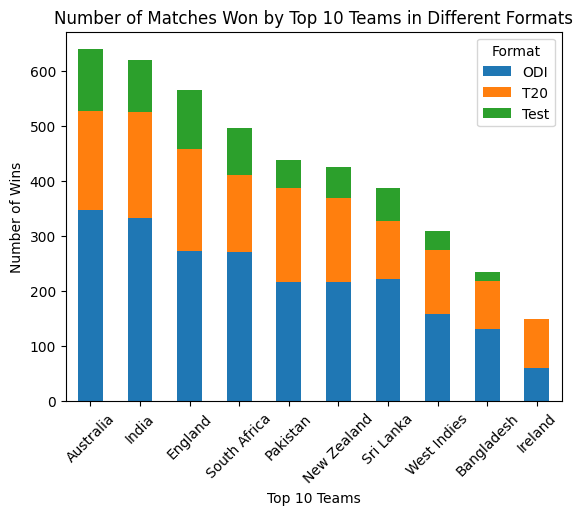

In [42]:
########################## visualizations fo Game Details ##########################################

import matplotlib.pyplot as plt

# Count the number of matches won by each team in each format
team_wins = game_details_df.groupby(["Team that Won", "Format"]).size().unstack(fill_value=0)

# Calculate total wins for each team
team_wins["Total Wins"] = team_wins.sum(axis=1)
top_teams = team_wins.nlargest(10, "Total Wins")

# Plotting
top_teams.drop("Total Wins", axis=1).plot(kind="bar", stacked=True)
plt.xlabel("Top 10 Teams")
plt.ylabel("Number of Wins")
plt.title("Number of Matches Won by Top 10 Teams in Different Formats")
plt.legend(title="Format")
plt.xticks(rotation=45)
plt.show()

Text(0.5, 1.0, 'Top Players by Man of the Match in Top 5 Countries')

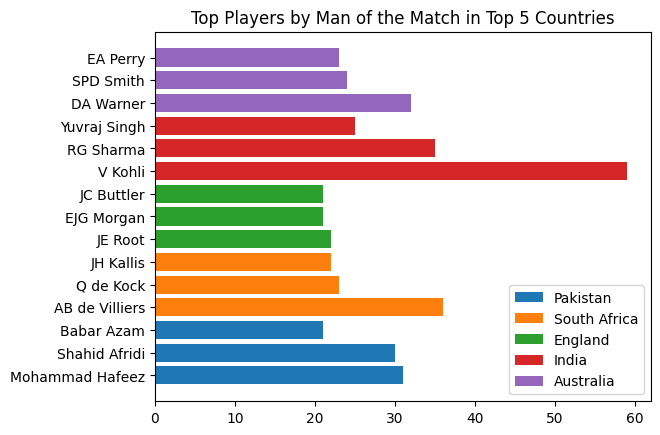

In [41]:
# Sort countries by wins
top_countries = game_details_df['Team that Won'].value_counts().index[:5]

# Reverse for descending order
top_countries = top_countries[::-1]

for country in top_countries:

  counts = game_details_df[game_details_df['Team that Won'] == country]['Man of the Match'].value_counts()[:3]

  # Sort players by Man of Match in descending order
  counts = counts.sort_values(ascending=False)

  players = counts.index
  values = counts.values

  plt.barh(players, values, label=country)

plt.legend(loc='lower right')
plt.title("Top Players by Man of the Match in Top 5 Countries")

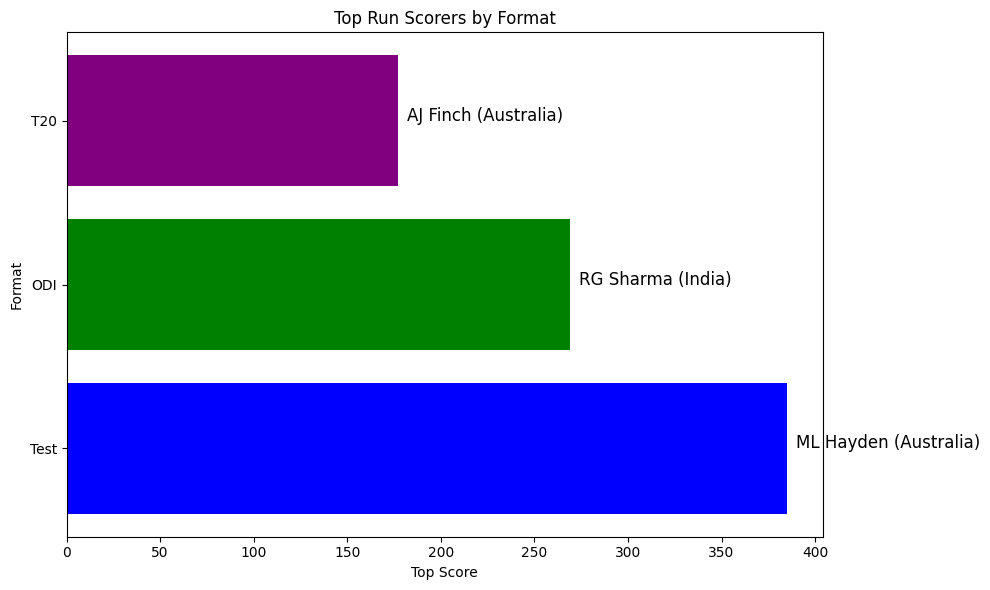

In [43]:
########################## visualizations fo Batsman Details ##########################################


import pandas as pd
import matplotlib.pyplot as plt

# Merge DataFrames
merged_df = pd.merge(batsman_df, game_details_df, on='PK')

# Filter by top teams
top_teams = game_details_df['Team that Won'].value_counts().index[:3]
merged_df = merged_df[merged_df['Team that Won'].isin(top_teams)]

# Get top scorers
top_scorers = {}
for format in ['Test', 'ODI', 'T20']:
    result = merged_df[merged_df['Format'] == format].groupby('Batsman')['Runs'].max().sort_values(ascending=False)
    top_scorer = result.index[0]
    top_score = result[0]
    country = merged_df.loc[merged_df['Batsman'] == top_scorer, 'Country'].iloc[0]

    top_scorers[format] = [top_scorer, country, top_score]

# Prepare data for plotting
formats = list(top_scorers.keys())
scorers = [x[0] for x in top_scorers.values()]
countries = [x[1] for x in top_scorers.values()]
top_scores = [x[2] for x in top_scorers.values()]

# Define different colors for each format
colors = {'Test': 'blue', 'ODI': 'green', 'T20': 'purple'}

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.barh(formats, top_scores, color=[colors[format] for format in formats])

# Annotate the bars with player names and countries
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, f"{scorers[i]} ({countries[i]})", fontsize=12)

plt.xlabel("Top Score")
plt.ylabel("Format")
plt.title("Top Run Scorers by Format")
plt.tight_layout()
plt.show()


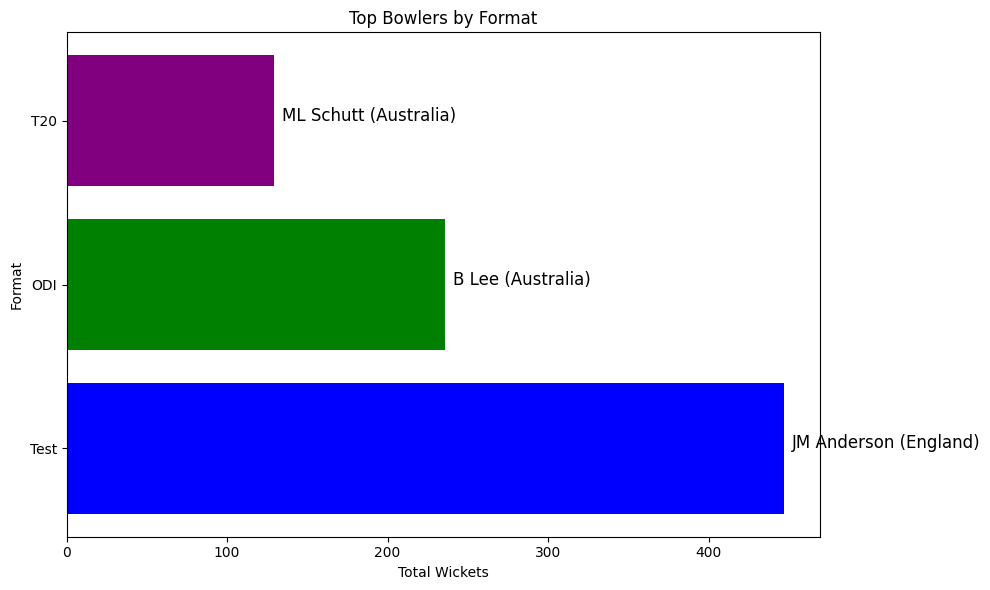

In [44]:
########################## visualizations fo Bowler Details ##########################################



import pandas as pd
import matplotlib.pyplot as plt

# Merge DataFrames
merged_df = pd.merge(bowler_df, game_details_df, on='PK')

# Filter by top teams
top_teams = game_details_df['Team that Won'].value_counts().index[:3]
merged_df = merged_df[merged_df['Team that Won'].isin(top_teams)]

# Get top bowlers
top_bowlers = {}
for format in ['Test', 'ODI', 'T20']:
    result = merged_df[merged_df['Format'] == format].groupby('Bowler')['Wickets Taken'].sum().sort_values(ascending=False)
    top_bowler = result.index[0]
    wickets = result[0]
    country = merged_df.loc[merged_df['Bowler'] == top_bowler, 'Team'].iloc[0]

    top_bowlers[format] = [top_bowler, country, wickets]

# Prepare data for plotting
formats = list(top_bowlers.keys())
bowlers = [x[0] for x in top_bowlers.values()]
countries = [x[1] for x in top_bowlers.values()]
total_wickets = [x[2] for x in top_bowlers.values()]

# Define different colors for each format
colors = {'Test': 'blue', 'ODI': 'green', 'T20': 'purple'}

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.barh(formats, total_wickets, color=[colors[format] for format in formats])

# Annotate the bars with bowler names and countries
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, f"{bowlers[i]} ({countries[i]})", fontsize=12)

plt.xlabel("Total Wickets")
plt.ylabel("Format")
plt.title("Top Bowlers by Format")
plt.tight_layout()
plt.show()


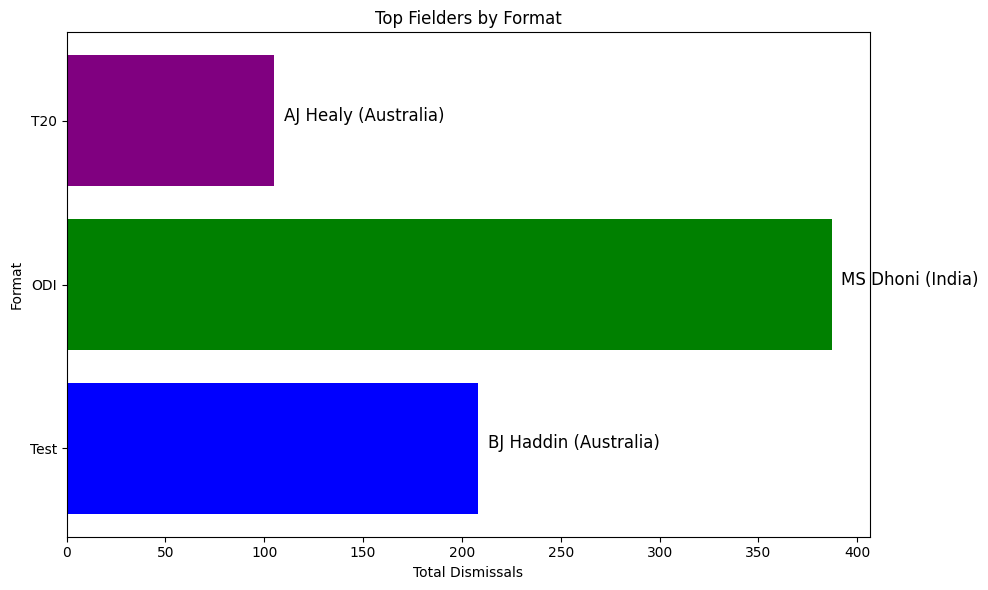

In [45]:
########################## visualizations fo Fielder Details ##########################################

import pandas as pd
import matplotlib.pyplot as plt

# Merge DataFrames
merged_df = pd.merge(fielder_df, game_details_df, on='PK')

# Filter by top teams
top_teams = game_details_df['Team that Won'].value_counts().index[:3]
merged_df = merged_df[merged_df['Team that Won'].isin(top_teams)]

# Get top fielders
top_fielders = {}
for format in ['Test', 'ODI', 'T20']:
    result = merged_df[merged_df['Format'] == format].groupby('Fielder')['Dismissals'].sum().sort_values(ascending=False)
    top_fielder = result.index[0]
    Dismissals = result[0]
    Team = merged_df.loc[merged_df['Fielder'] == top_fielder, 'Team'].iloc[0]

    top_fielders[format] = [top_fielder, Team, Dismissals]

# Prepare data for plotting
formats = list(top_fielders.keys())
fielders = [x[0] for x in top_fielders.values()]
countries = [x[1] for x in top_fielders.values()]
total_catches = [x[2] for x in top_fielders.values()]

# Define different colors for each format
colors = {'Test': 'blue', 'ODI': 'green', 'T20': 'purple'}

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.barh(formats, total_catches, color=[colors[format] for format in formats])

# Annotate the bars with fielder names and countries
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, f"{fielders[i]} ({countries[i]})", fontsize=12)

plt.xlabel("Total Dismissals")
plt.ylabel("Format")
plt.title("Top Fielders by Format")
plt.tight_layout()
plt.show()
